
[구내식당 식수 인원 예측 AI 경진대회](https://dacon.io/competitions/official/235743/overview/description)
* 데이터 출처 : DACON, 한국토지주택공사
* 평가방식 : MAE(Mean Absolute Error)

## 1. 기본 설정

### 라이브러리 로드

In [185]:
import pandas as pd
import numpy as np
from glob import glob
import os
import warnings 

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import seaborn.objects as so
import koreanize_matplotlib

import warnings 
warnings.filterwarnings(action='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.size'] = 15
cmap='RdYlGn_r'

# 한글폰트
!pip install koreanize-matplotlib
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

### 데이터셋 로드

In [186]:
train = pd.read_csv('data/train.csv', encoding = 'utf-8',dtype={'중식계':'int32', '석식계':'int32'})    
test = pd.read_csv('data/test.csv', encoding = 'utf-8', dtype={'중식계':'int32', '석식계':'int32'})
submission = pd.read_csv('data/sample_submission.csv', encoding = 'utf-8')


print(f"""train shape : {train.shape},
test shape : {test.shape}""")

train shape : (1205, 12),
test shape : (50, 10)


### 파생변수 생성

In [187]:
# '일자' 컬럼의 dtype을 datetime으로 변경
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

# 파생변수 : 요일 => 기존 컬럼에 오타 있음 ('2018-06-01' 월) => 새로 생성.
train['dayofweek'] = train['일자'].dt.dayofweek
train['요일'] = train['dayofweek'].map(lambda x: "월화수목금토일"[x])
test['dayofweek'] = test['일자'].dt.dayofweek
test['요일'] = test['dayofweek'].map(lambda x: "월화수목금토일"[x])

# 파생변수 : 월
train['month'] = train['일자'].dt.month
test['month'] = test['일자'].dt.month

# 파생변수 : 연도월
train['yearmonth'] = train['일자'].astype(str).str[:-3]
test['yearmonth'] = test['일자'].astype(str).str[:-3]

# 너무 긴 컬럼명 수정
columns_rename = {'본사시간외근무명령서승인건수':'야근자수', '현본사소속재택근무자수':'재택근무자수'}
train = train.rename(columns=columns_rename)
test = test.rename(columns=columns_rename)


display(train.head(1), test.head(1))

,일자,요일,본사정원수,본사휴가자수,본사출장자수,야근자수,재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,dayofweek,month,yearmonth
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,0,2,2016-02


,일자,요일,본사정원수,본사휴가자수,본사출장자수,야근자수,재택근무자수,조식메뉴,중식메뉴,석식메뉴,dayofweek,month,yearmonth
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2,1,2021-01


## 2. 데이터 요약

### raw 데이터 확인 : 결측치, 데이터타입, 기술통계값

In [188]:
# 결측치 없음
train.isnull().sum().sum()

0

In [189]:
# 변수는 일자(datetime)을 제외하고는 모두 수치형(numeric)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         1205 non-null   datetime64[ns]
 1   요일         1205 non-null   object        
 2   본사정원수      1205 non-null   int64         
 3   본사휴가자수     1205 non-null   int64         
 4   본사출장자수     1205 non-null   int64         
 5   야근자수       1205 non-null   int64         
 6   재택근무자수     1205 non-null   float64       
 7   조식메뉴       1205 non-null   object        
 8   중식메뉴       1205 non-null   object        
 9   석식메뉴       1205 non-null   object        
 10  중식계        1205 non-null   int32         
 11  석식계        1205 non-null   int32         
 12  dayofweek  1205 non-null   int64         
 13  month      1205 non-null   int64         
 14  yearmonth  1205 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(6), object(5)
memory usage: 131.9+ KB


In [190]:
# 석식계, 시간외근무, 재택근무자수 : min값이 0. > 확인 필요.
# 휴가자수, 시간외근무 : max값이 1224, 1044. >  인원 변동이 한꺼번에 이루어지는 경우도 있다.
# 재택근무자수 : max값은 533, 75%까지는 모두 0. > 코로나로 일시적이었을 것으로 예상됨.
train.describe()

,본사정원수,본사휴가자수,본사출장자수,야근자수,재택근무자수,중식계,석식계,dayofweek,month
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614,2.006639,6.512033
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202,1.415372,3.453906
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000,0.000000,1.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000,1.000000,4.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000,2.000000,7.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000,3.000000,9.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000,4.000000,12.000000


### hist, corr

파생변수 생성
* 출근인원 = 본사정원수 - (휴가자수 + 출장자수 + 재택근무자수)
* 

In [191]:
# 출근인원
train['출근인원'] = train['본사정원수'] - (train['본사휴가자수'] + train['본사출장자수'] + train['재택근무자수'])
train['출근인원'] = train['출근인원'].astype(int)

In [192]:
train["최대식사가능자수"] = train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['재택근무자수']
train["총인원"] = train['본사정원수'] + train['본사휴가자수'] + train['본사출장자수'] + train['재택근무자수']

In [193]:
# 비율 파생변수 생성
train['중식비율'] = train['중식계'] / train['출근인원']
train['석식비율'] = train['석식계'] / train['출근인원']

### 변수별 분포, 상관관계

#### 전체 변수

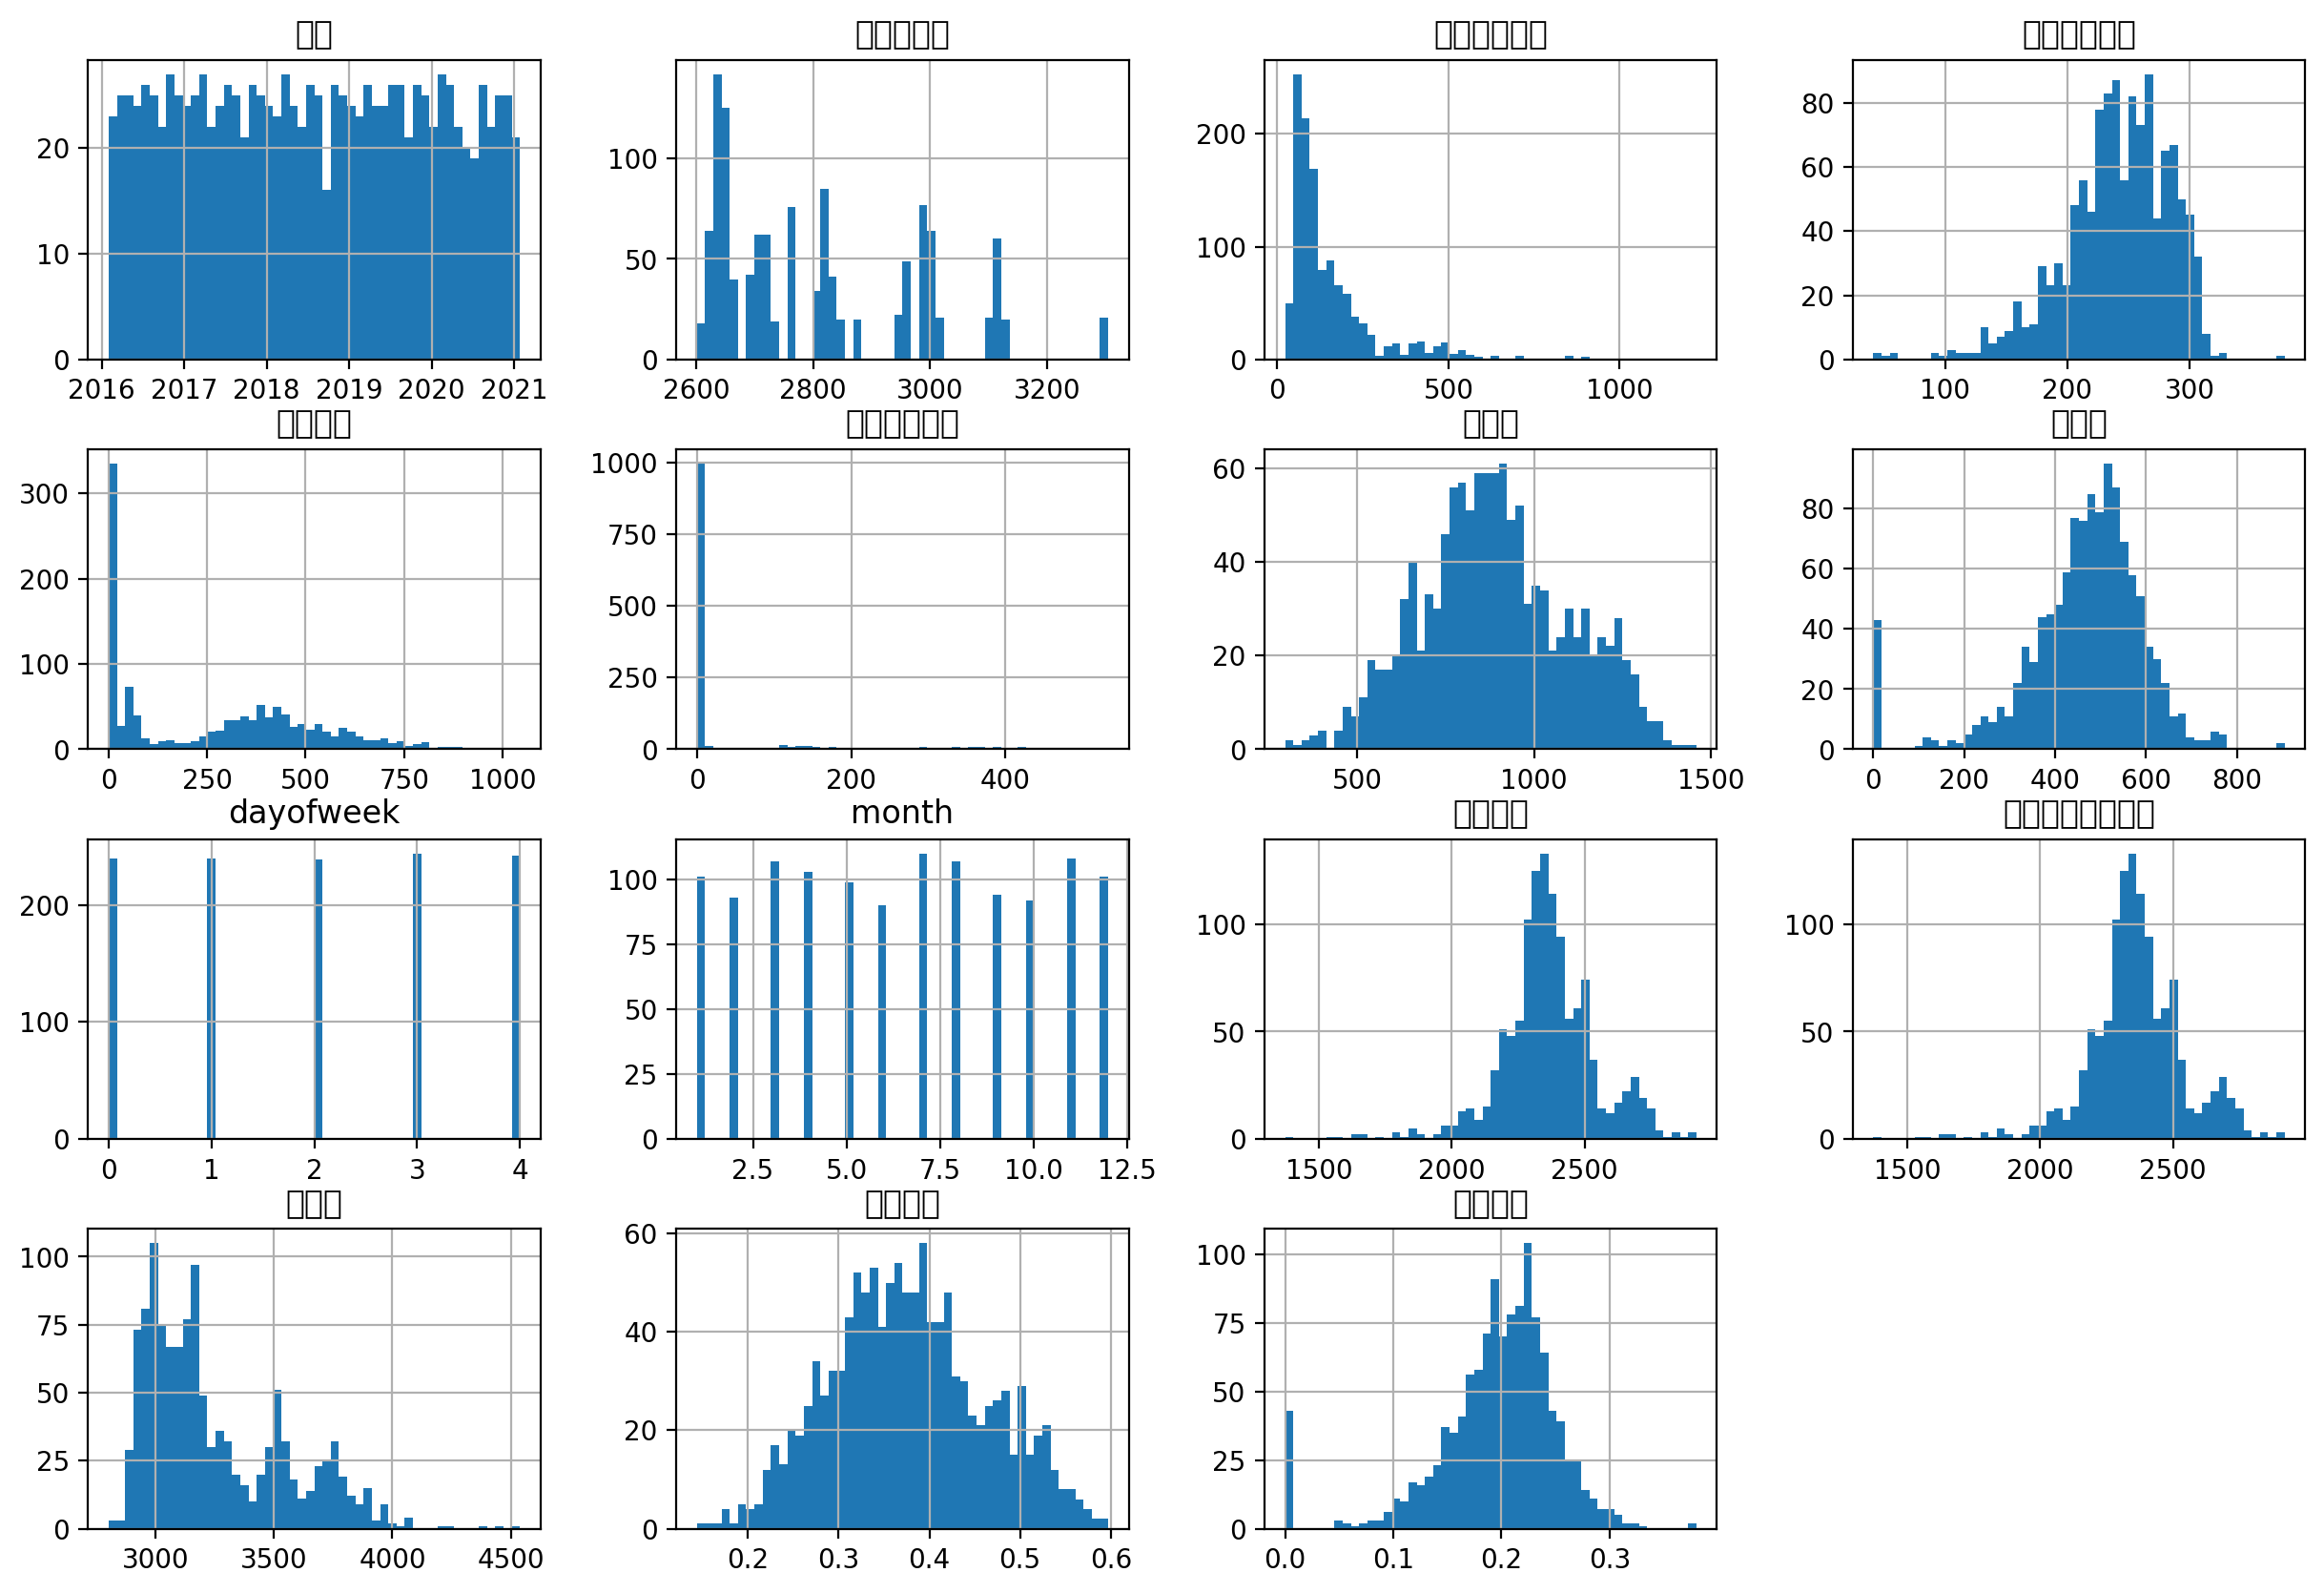

In [194]:
# 중식계, 석식계(0 제외), 출근인원 변수는 비교적 고르게 분포되어 있음
train.hist(bins=50, figsize=(15, 10));

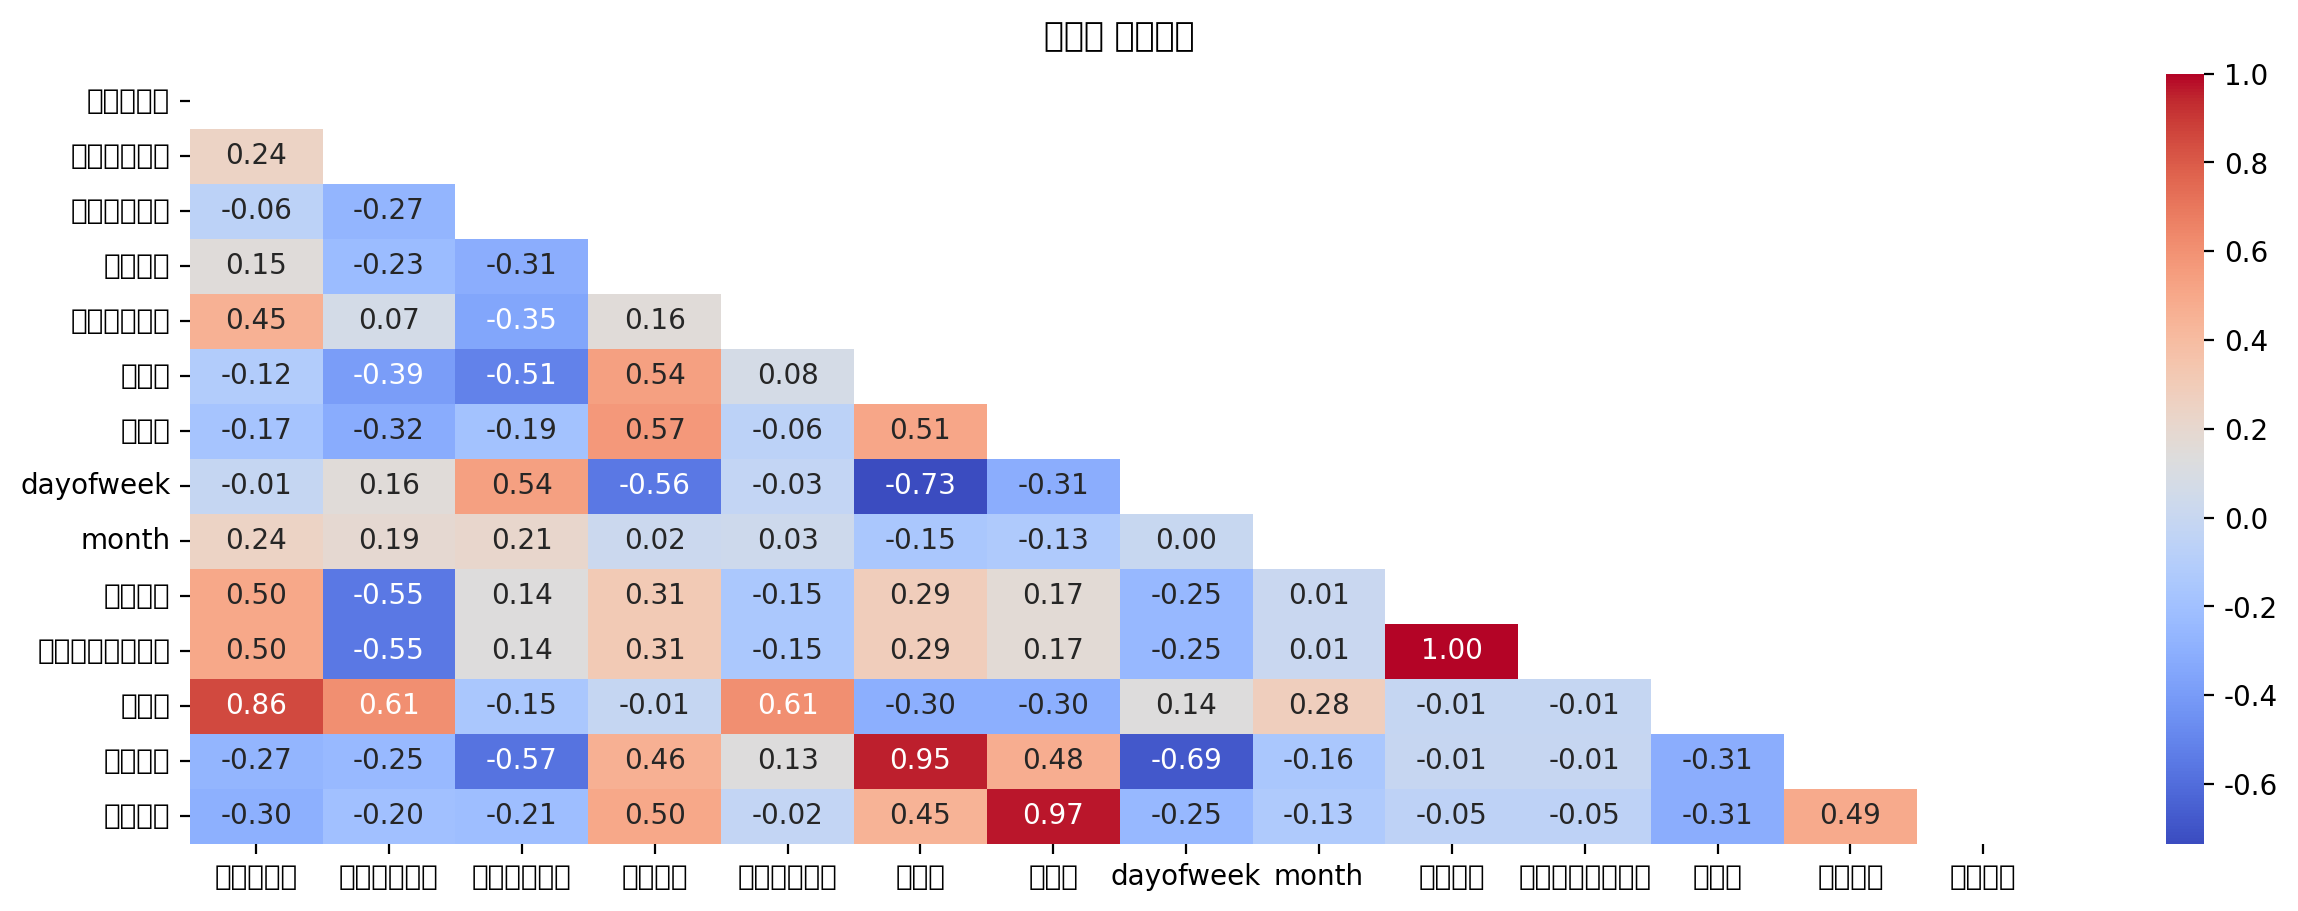

In [195]:
# 변수별 상관관계
mask = np.triu(np.ones_like(train.corr(numeric_only=True)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(train.corr(numeric_only=True), 
            annot=True, fmt='.2f', mask=mask, cmap='coolwarm')
ax.set_title('변수별 상관관계', pad=10)
plt.show;

#### 중식계, 석식계 (target)

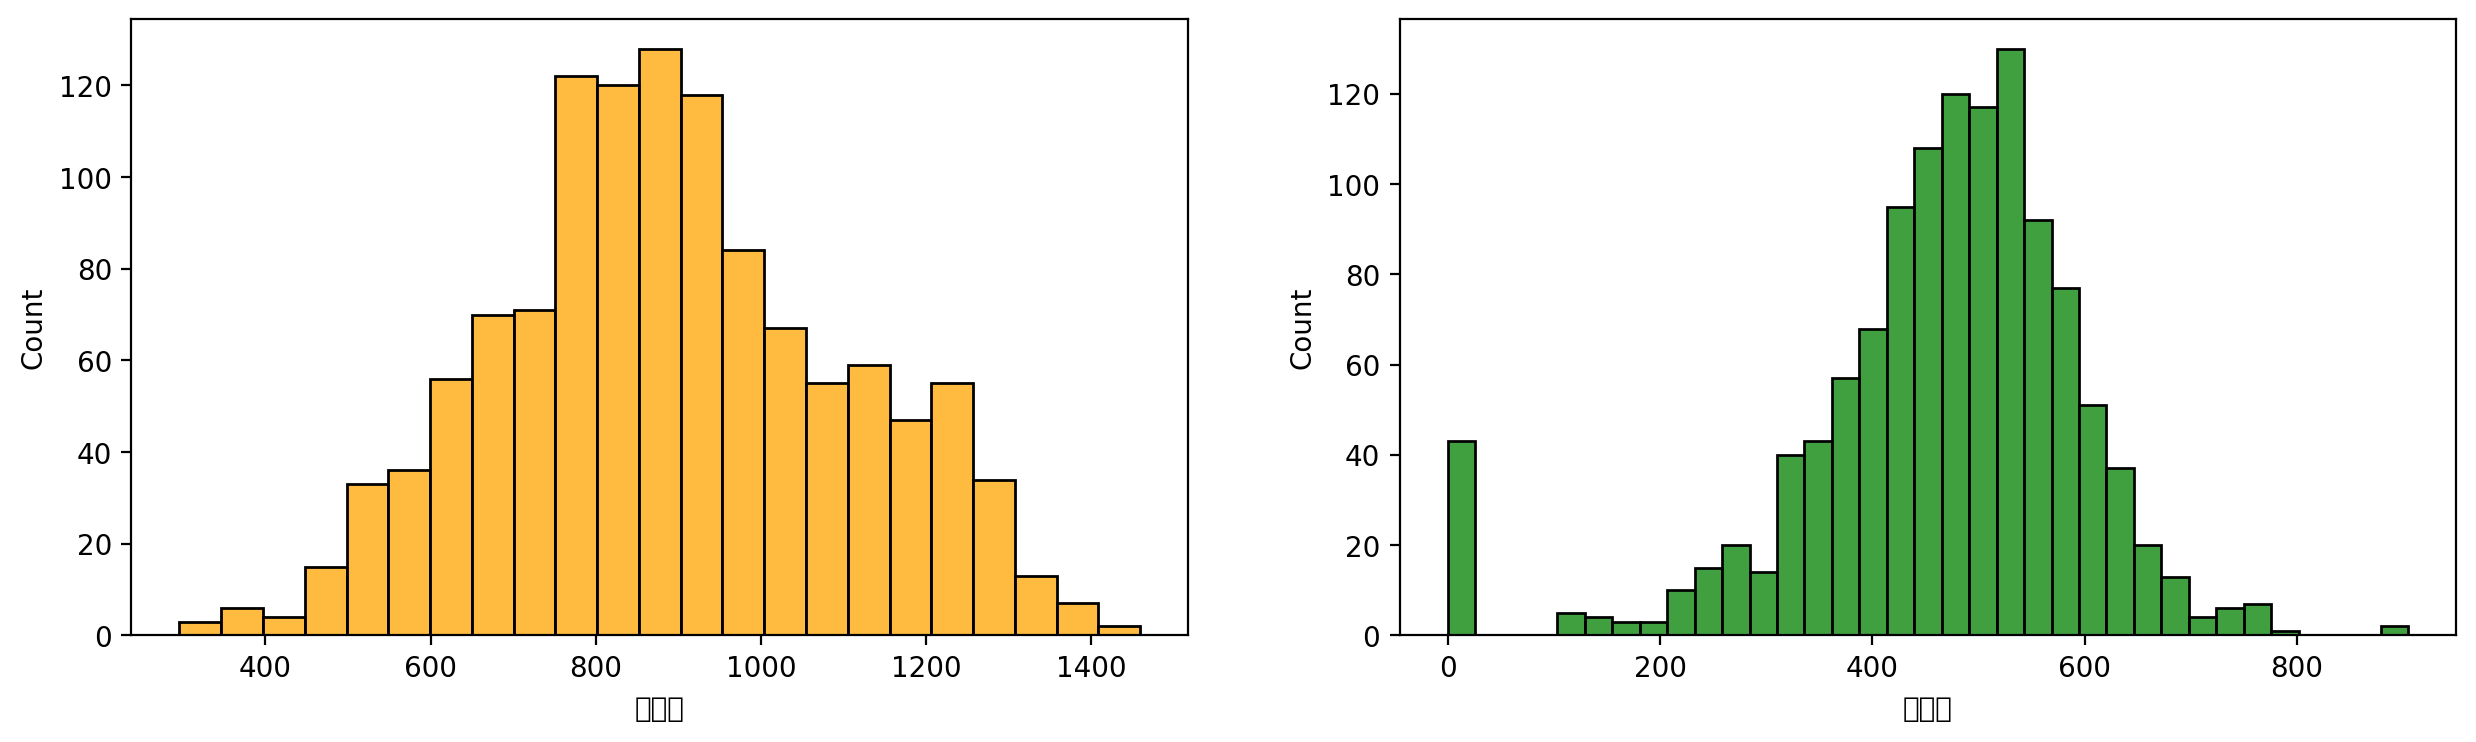

In [196]:
# 점심, 저녁 이용자수 (확대))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.histplot(train['중식계'], ax=ax[0], color='orange')
sns.histplot(train['석식계'], ax=ax[1], color='green')
plt.show()

## 3. 주요 변수 분석

### 시간에 따라서

#### 인원 추이
휴가, 출장, 야근, 재택근무

In [197]:
train_YM = train.groupby('yearmonth').mean(numeric_only=True)
fig = px.line(train_YM.iloc[:, :-5], width=1000, title="연도월 ~ 인원 추이 (명)")
fig.show()

#### 점심/저녁 이용자 추이

In [198]:
fig = px.line(train_YM.iloc[:, -5:-2], range_y=(0, 3000), width=1000, title="연도월 ~ 점심/저녁 이용자 추이 (명)")
fig.show()

### 요일, 월에 따라서

#### 인원

In [199]:
# 요일/월 ~ 집계(평균))
dow_month = train.groupby(['dayofweek', 'month']).mean(1).unstack()

# heatmap (반복부분)
def plot_heatmap(data, cmap, ax_num, title) :
    sns.heatmap(data, cmap=cmap, ax=ax[ax_num])
    ax[ax_num].set_title(title)

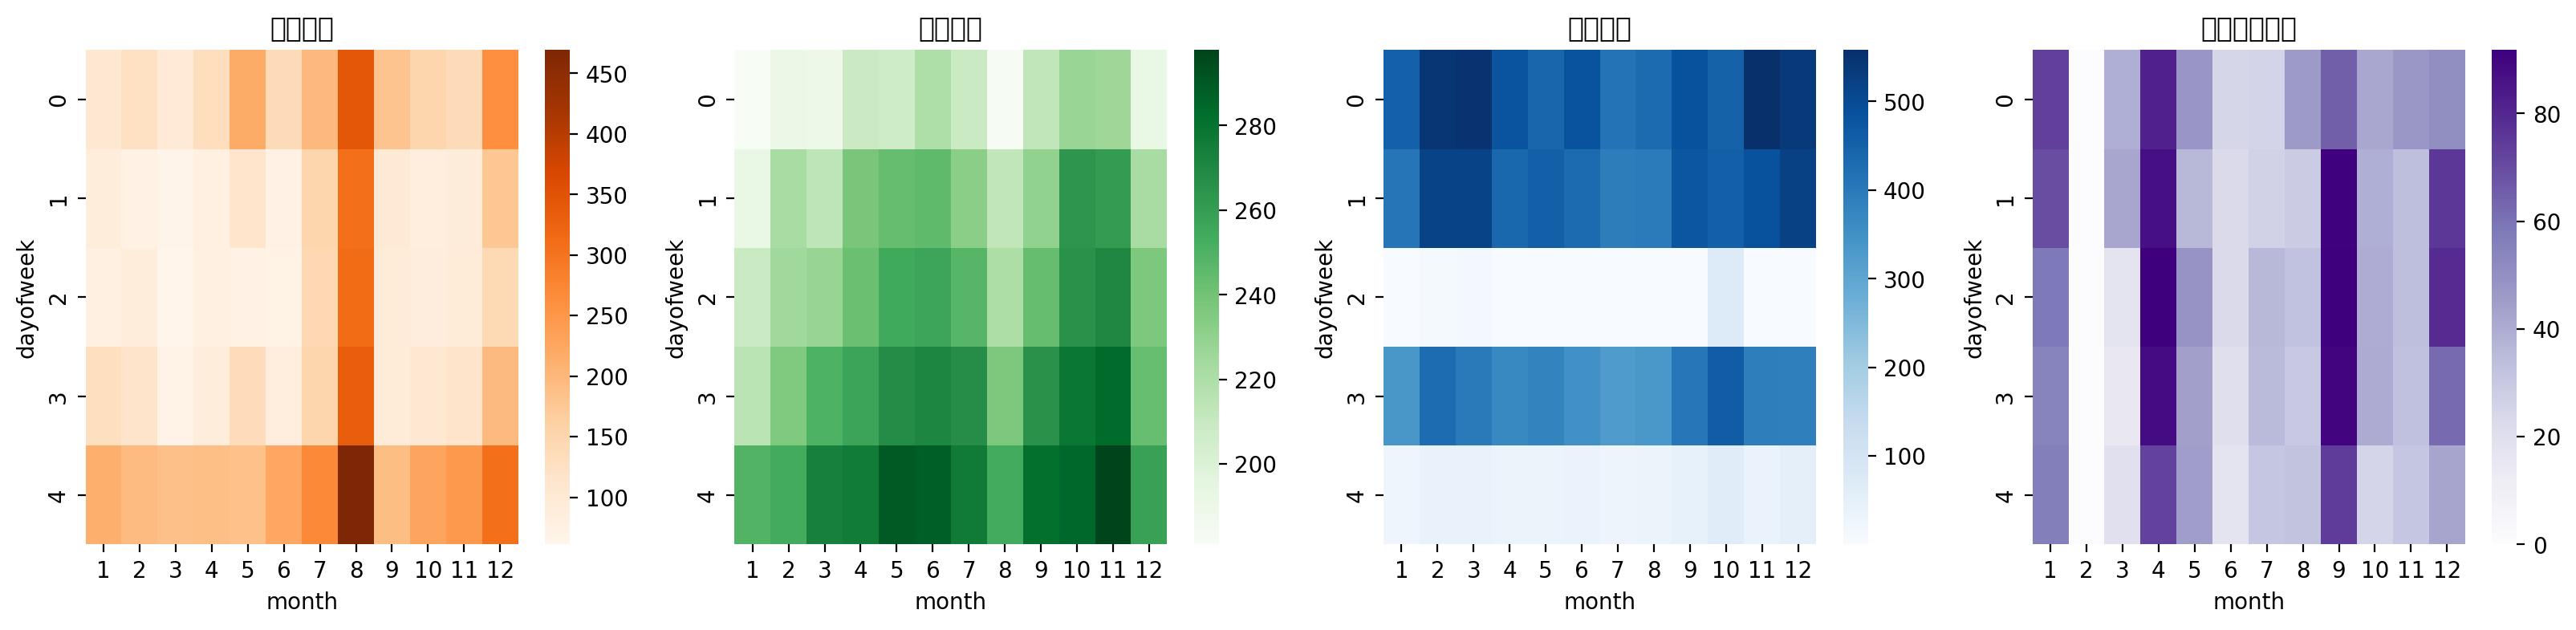

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
plot_heatmap(dow_month['본사휴가자수'], 'Oranges', 0, '휴가인원')
plot_heatmap(dow_month['본사출장자수'], 'Greens', 1, '출장인원')
plot_heatmap(dow_month['야근자수'], 'Blues', 2, '야근인원')
plot_heatmap(dow_month['재택근무자수'], 'Purples', 3, '재택근무인원')
plt.show();

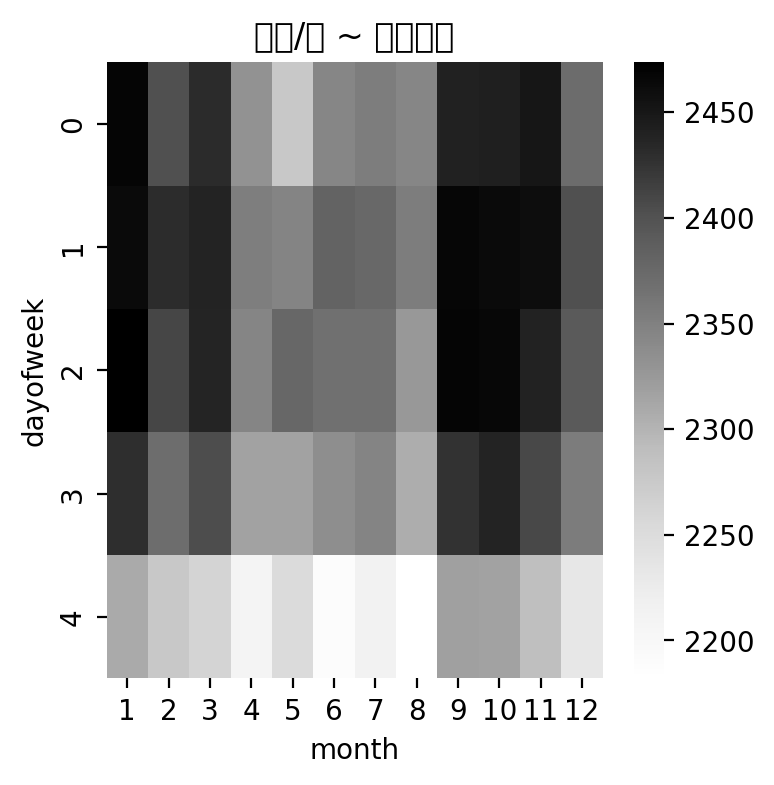

In [201]:
plt.figure(figsize=(4, 4))
plt.title("요일/월 ~ 출근인원")
sns.heatmap(dow_month['출근인원'], cmap='Greys');

#### 중식계, 석식계

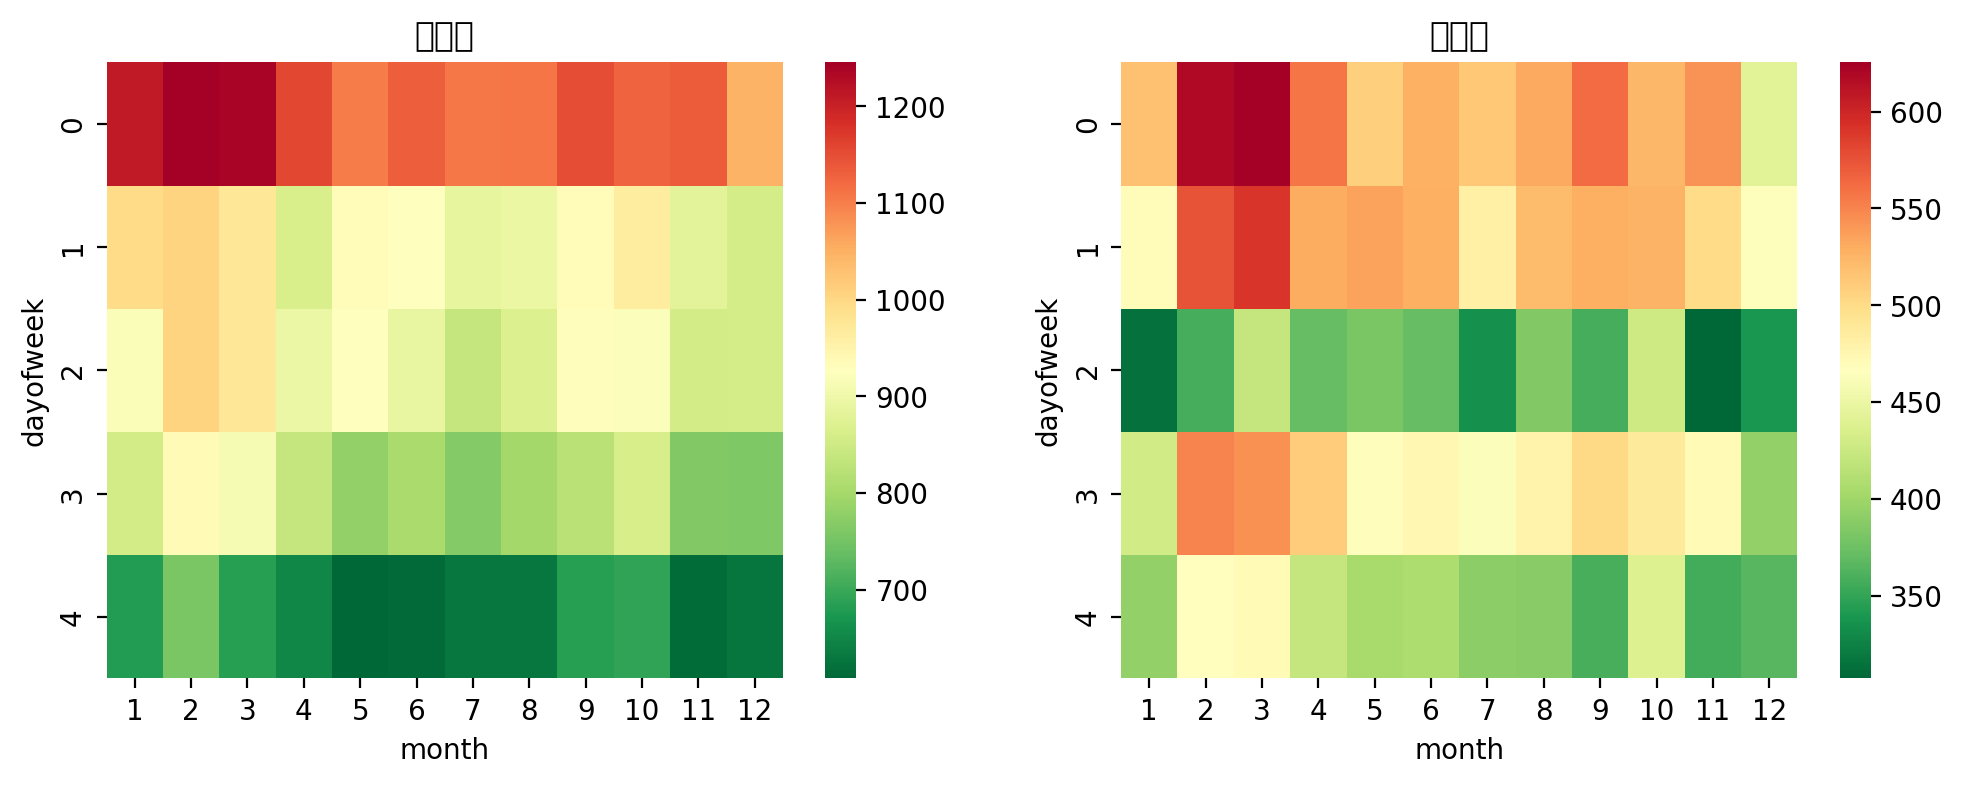

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plot_heatmap(dow_month['중식계'], cmap, 0, '중식계')
plot_heatmap(dow_month['석식계'], cmap, 1, '석식계')
plt.show()

#### 출근인원 대비 중식/석식 이용 인원
위의 플롯과 거의 차이 없음.

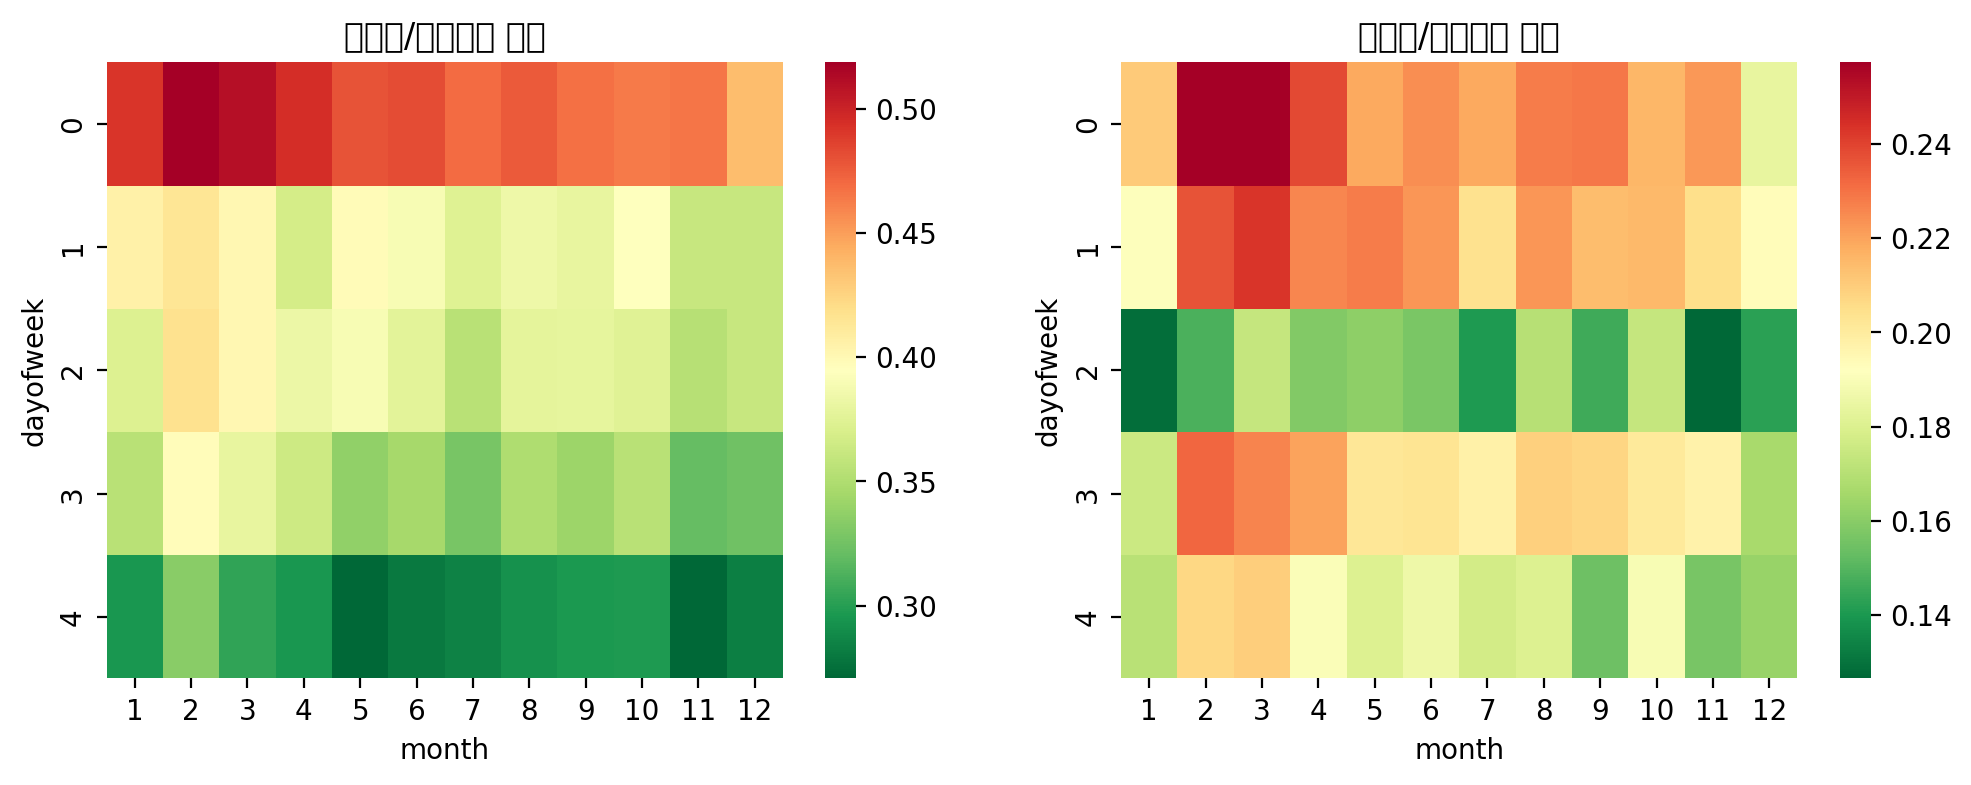

In [203]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plot_heatmap(dow_month['중식비율'], cmap, 0, '중식계/출근인원 비율')
plot_heatmap(dow_month['석식비율'], cmap, 1, '석식계/출근인원 비율')
plt.show()

### 요일에 따라서

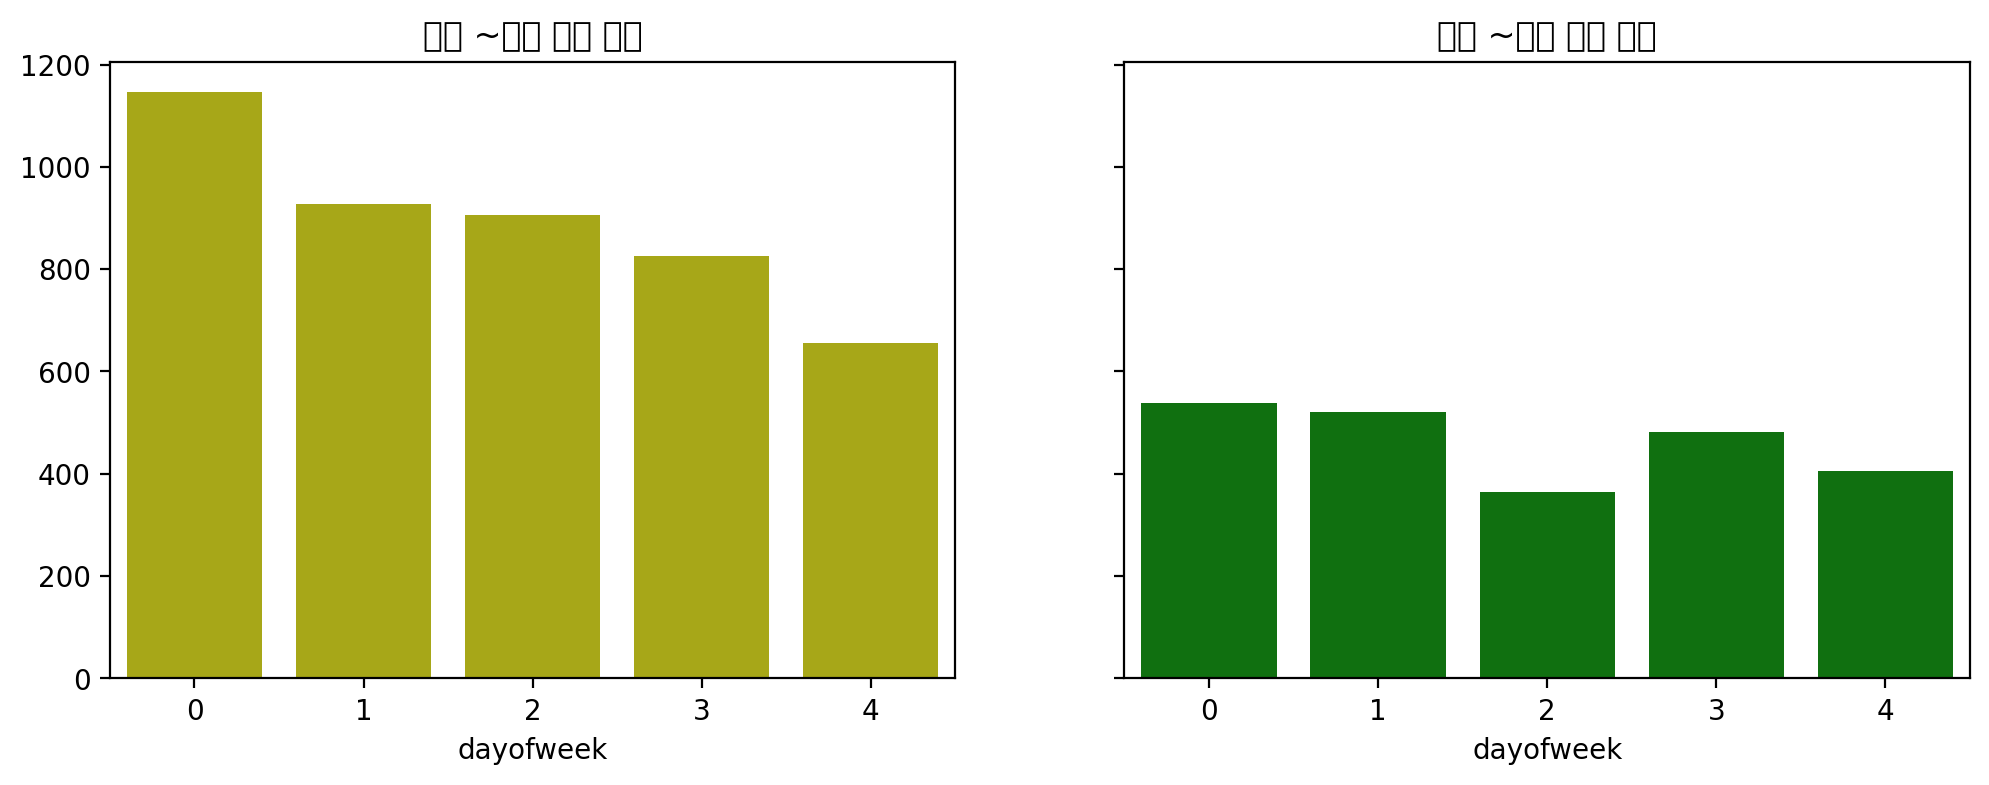

In [204]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
sns.barplot(pd.DataFrame(dow_month['중식계'].mean(axis=1)).T, color='y', ax=ax[0])
ax[0].set_title('요일 ~점심 이용 인원')
sns.barplot(pd.DataFrame(dow_month['석식계'].mean(axis=1)).T, color='g', ax=ax[1],)
ax[1].set_title('요일 ~저녁 이용 인원')
plt.show()

## 메뉴 (text)

### 메뉴 텍스트 데이터

* 순서 : 밥, 국, 반찬1, 반찬2, 반찬3, 후식, 김치 순으로 되어 있음. (1067행부터는 후식, 김치 순서가 바뀜)
* 원산지 : () 안에는 원산지가 표시되어 있음.
* New : 새로운 메뉴가 나오는 경우 (New)로 표시되어 있음.

In [205]:
display(train[['중식메뉴', '석식메뉴']].head(2), train[['중식메뉴', '석식메뉴']].tail(3))

,중식메뉴,석식메뉴
0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ..."
1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무..."


,중식메뉴,석식메뉴
1202,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치
1203,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치
1204,쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...,(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기


In [206]:
# 밥, 김치는 거의 매일 나옴.
print(f"""feaquancy가 거의 1인 메뉴
밥 : {round(train['중식메뉴'].str.contains("밥").value_counts(1)[0], 2)}, {round(train['석식메뉴'].str.contains("밥").value_counts(1)[0], 2)}
김치 : {round(train['중식메뉴'].str.contains("김치").value_counts(1)[0], 2)}, {round(train['석식메뉴'].str.contains("김치").value_counts(1)[0], 2)}
배추 : {round(train['중식메뉴'].str.contains("배추").value_counts(1)[0], 2)}, {round(train['석식메뉴'].str.contains("배추").value_counts(1)[0], 2)}""")

feaquancy가 거의 1인 메뉴
밥 : 0.99, 0.92
김치 : 0.97, 0.94
배추 : 0.78, 0.84


### 메뉴 유형별 분리

In [207]:
# 오타 수정 (괄호가 안닫히는 경우)
train.loc[1003, '중식메뉴'] = '카레라이스 (쌀:국내산, 돈육:국내) 미소시루  감자만두*양념  애기새송이버섯볶음  골뱅이야채무침  포기김치 (김치:국내산) '

# () 안의 단어 확인
# display(pd.DataFrame(train['중식메뉴'].str.extractall(r"\(([^)]*)\)",).value_counts()))

# # () 안의 원산지 표기 삭제
# train['중식메뉴_'] = train['중식메뉴'].str.replace("\([^)]*\)", "", regex=True)
# train['석식메뉴_'] = train['석식메뉴'].str.replace("\([^)]*\)", "", regex=True)

In [208]:
중식메뉴_list = []
for menus in train['중식메뉴'].str.split(" ") :
    menus = ' '.join(menus).split() # 빈 원소 삭제
    중식메뉴_list.append([menu for menu in menus if "(" not in menu])

밥 = []; 국 = []; 반찬1 = []; 반찬2 = []; 반찬3 = []; 김치 = []; 사이드 = []
for i, menu in enumerate(중식메뉴_list):
    밥.append(menu[0])
    국.append(menu[1])
    반찬1.append(menu[2])
    반찬2.append(menu[3])
    반찬3.append(menu[4])

    if i < 1067:
        김치.append(menu[-1])
        사이드.append(menu[-2])
    else: 
        김치.append(menu[-2])
        사이드.append(menu[-1])

밥[:3], 국[:3], 반찬1[:3], 반찬2[:3], 반찬3[:3], 김치[:3], 사이드[:3]

(['쌀밥/잡곡밥', '쌀밥/잡곡밥', '카레덮밥'],
 ['오징어찌개', '김치찌개', '팽이장국'],
 ['쇠불고기', '가자미튀김', '치킨핑거'],
 ['계란찜', '모둠소세지구이', '쫄면야채무침'],
 ['청포묵무침', '마늘쫑무침', '견과류조림'],
 ['포기김치', '배추겉절이', '포기김치'],
 ['요구르트', '요구르트', '요구르트'])

In [209]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '야근자수', '재택근무자수', '조식메뉴',
       '중식메뉴', '석식메뉴', '중식계', '석식계', 'dayofweek', 'month', 'yearmonth', '출근인원',
       '최대식사가능자수', '총인원', '중식비율', '석식비율'],
      dtype='object')

In [210]:
train_ln = train[['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '야근자수', '재택근무자수', '중식메뉴', '중식계']]
train_ln['밥'] = 밥
train_ln['국'] = 국
train_ln['반찬1'] = 반찬1; train_ln['반찬2'] = 반찬2; train_ln['반찬3'] = 반찬3
train_ln['김치'] = 김치 
train_ln['사이드'] = 사이드

In [211]:
# 확인 
중식메뉴_list[0:5]

[['쌀밥/잡곡밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '떡국', '돈육씨앗강정', '우엉잡채', '청경채무침', '요구르트', '포기김치']]

In [212]:
중식메뉴_list[1065:1070]

[['쌀밥/잡곡밥', '매운소고기국', '굴비구이', '토마토프리타타', '도라지오이무침', '배추겉절이'],
 ['돈육버섯고추장덮밥', '팽이무국', '양파링카레튀김', '모듬어묵볶음', '참나물생채', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '냉모밀국수', '매운돈갈비찜', '메밀전병*간장', '고구마순볶음', '포기김치', '양상추샐러드*딸기요거트'],
 ['쌀밥/잡곡밥', '대파육개장', '홍어미나리초무침', '어묵잡채', '콩자반', '배추겉절이', '양상추샐러드*오리엔탈'],
 ['카레라이스', '동태알탕', '부추고추전*간장', '쫄면야채무침', '과일요거트샐러드', '포기김치', '요구르트']]

In [213]:
np.array(train[ (train.index > 1064) & (train.index < 1069)][['일자', '석식메뉴']])

array([[Timestamp('2020-06-11 00:00:00'),
        '야채볶음밥 (쌀:국내산) 초계국수 (닭:국내산) 코코넛새우튀김  옥수수콘치즈  음료  포기김치 (배추국내,고추가루:중국산) '],
       [Timestamp('2020-06-12 00:00:00'),
        '쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 부대찌개 (양지:호주산) 떡갈비조림  쫄면무침  무나물들깨볶음  포기김치 (배추국내,고추가루:중국산) '],
       [Timestamp('2020-07-01 00:00:00'),
        '쌀밥/잡곡밥 돈육김치찌개 깐풍기 고갈비구이 가지된장무침 포기김치 '],
       [Timestamp('2020-07-02 00:00:00'),
        '김밥 미니우동 구슬떡볶이 김말이,고추튀김 다시마채무초무침 포기김치 ']], dtype=object)

In [214]:
train_ln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      1205 non-null   datetime64[ns]
 1   요일      1205 non-null   object        
 2   본사정원수   1205 non-null   int64         
 3   본사휴가자수  1205 non-null   int64         
 4   본사출장자수  1205 non-null   int64         
 5   야근자수    1205 non-null   int64         
 6   재택근무자수  1205 non-null   float64       
 7   중식메뉴    1205 non-null   object        
 8   중식계     1205 non-null   int32         
 9   밥       1205 non-null   object        
 10  국       1205 non-null   object        
 11  반찬1     1205 non-null   object        
 12  반찬2     1205 non-null   object        
 13  반찬3     1205 non-null   object        
 14  김치      1205 non-null   object        
 15  사이드     1205 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(9)
memory usage: 146.0+ KB


### 자주 나오는 메뉴 분석

In [215]:
# 반찬 1, 2, 3 이 겹치기도 함.
print(len(set(반찬1)) + len(set(반찬2)) + len(set(반찬3)))
print(len(set(반찬1 + 반찬2 + 반찬3)))

1305
1175


In [216]:
pd.Series(김치).value_counts()

포기김치          830
배추겉절이          94
열무김치           67
깍두기            61
알타리김치          54
             ... 
포기김치/사과/식혜      1
포기김치/인절미        1
총각김치            1
포기김치/찹쌀호떡       1
봄동겉절이/양념김       1
Length: 76, dtype: int64

In [217]:
from sklearn.feature_extraction.text import CountVectorizer

In [218]:
import re

In [219]:
# 중식 
중식메뉴 = []
for i in range(len(train)):
    
    # 정규표현식을 사용해 원산지 및 소스 명 제거하기
    pattern = r'\*[^ ]+|\([^)]*\)'
    tmp_2 = re.sub(pattern, '', train["중식메뉴"][i]).split()
    중식메뉴.append(tmp_2)

In [220]:
중식메뉴[:5]

[['쌀밥/잡곡밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '떡국', '돈육씨앗강정', '우엉잡채', '청경채무침', '요구르트', '포기김치']]

In [221]:
max_len = max(len(menu) for menu in 중식메뉴)

밥 = []; 국 = []; 반찬1 = []; 반찬2 = []; 반찬3 = []; 김치 = []; 사이드 = [];

for i, menu in enumerate(중식메뉴):
    밥.append(menu[0] if len(menu) >= 1 else '')
    국.append(menu[1] if len(menu) >= 2 else '')
    반찬1.append(menu[2] if len(menu) >= 3 else '')
    반찬2.append(menu[3] if len(menu) >= 4 else '')
    반찬3.append(menu[4] if len(menu) >= 5 else '')

    if i < 1067:
        김치.append(menu[-1] if len(menu) >= 6 else '')
        사이드.append(menu[-2] if len(menu) >= 5 else '')
    else: 
        김치.append(menu[-2] if len(menu) >= 6 else '')
        사이드.append(menu[-1] if len(menu) >= 5 else '')
밥[:3],국[:3], 반찬1[:3], 반찬2[:3], 반찬3[:3], 김치[:3], 사이드[:3] 

(['쌀밥/잡곡밥', '쌀밥/잡곡밥', '카레덮밥'],
 ['오징어찌개', '김치찌개', '팽이장국'],
 ['쇠불고기', '가자미튀김', '치킨핑거'],
 ['계란찜', '모둠소세지구이', '쫄면야채무침'],
 ['청포묵무침', '마늘쫑무침', '견과류조림'],
 ['포기김치', '배추겉절이', '포기김치'],
 ['요구르트', '요구르트', '요구르트'])

## 리스트에서 각각의 메뉴 종류별로 어떤 음식들이 많이 나왔나

In [222]:
from collections import Counter

# 각 메뉴 종류별로 음식 종류별 빈도수 측정
count_밥 = Counter(밥)
count_국 = Counter(국)
count_반찬1 = Counter(반찬1)
count_반찬2 = Counter(반찬2)
count_반찬3 = Counter(반찬3)
count_김치 = Counter(김치)
count_사이드 = Counter(사이드)

# 각 메뉴 종류별로 가장 많이 나온 음식 5개 출력
print("밥: ", count_밥.most_common(5))
print("\n국: ", count_국.most_common(5))
print("\n반찬1: ", count_반찬1.most_common(5))
print("\n반찬2: ", count_반찬2.most_common(5))
print("\n반찬3: ", count_반찬3.most_common(5))
print("\n김치: ", count_김치.most_common(5))
print("\n사이드: ", count_사이드.most_common(5))

밥:  [('쌀밥/잡곡밥', 879), ('쌀밥/흑미밥/찰현미밥', 74), ('곤드레밥', 30), ('콩나물밥', 30), ('카레덮밥', 18)]

국:  [('맑은국', 46), ('콩나물국', 44), ('된장찌개', 37), ('어묵국', 31), ('배추된장국', 28)]

반찬1:  [('오징어볶음', 39), ('닭갈비', 30), ('버섯불고기', 29), ('훈제오리구이', 27), ('돈육굴소스볶음', 25)]

반찬2:  [('계란말이', 27), ('계란찜', 24), ('새송이버섯전', 24), ('골뱅이무침', 20), ('우엉잡채', 18)]

반찬3:  [('오이무침', 34), ('콩나물무침', 28), ('숙주나물', 24), ('무생채', 22), ('시금치나물', 21)]

김치:  [('포기김치', 829), ('배추겉절이', 94), ('열무김치', 67), ('깍두기', 61), ('알타리김치', 54)]

사이드:  [('양상추샐러드', 77), ('오이무침', 33), ('콩나물무침', 26), ('숙주나물', 23), ('요구르트', 22)]


In [223]:
#밥 + 국 + 반찬1 + 반찬2 + 반찬3 + 김치 + 사이드
def visualize_most_common(menu_list, n=5):
    menu_count = Counter(menu_list)
    most_common = menu_count.most_common(n)
    plt.bar([menu[0] for menu in most_common], [menu[1] for menu in most_common])
    plt.xticks(rotation=90)
    plt.show()
    return most_common

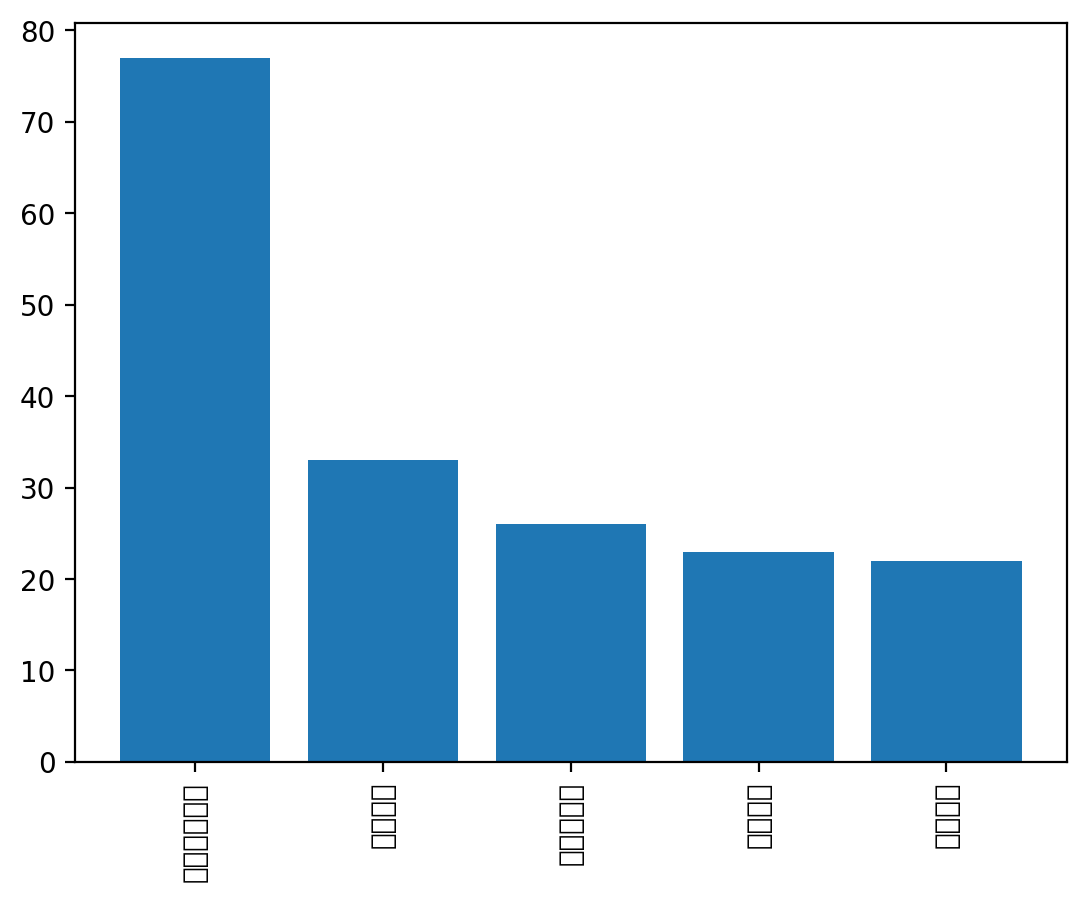

[('양상추샐러드', 77), ('오이무침', 33), ('콩나물무침', 26), ('숙주나물', 23), ('요구르트', 22)]

In [224]:
visualize_most_common(사이드)

## 밥 + 국 많이 나온 조합 빈도수

In [225]:
# 각각의 메뉴 조합에 대해 Counter 객체 생성
menu_combinations = []
for i in range(len(밥)):
    combination = 밥[i] + '+' + 국[i]
    menu_combinations.append(combination)

In [226]:
# 가장 많이 나온 상위 10개 메뉴 조합 출력
menu_count_combinations = Counter(menu_combinations)
most_common_combinations = menu_count_combinations.most_common(10)

In [227]:
print(most_common_combinations)

[('쌀밥/잡곡밥+콩나물국', 43), ('쌀밥/잡곡밥+된장찌개', 35), ('쌀밥/잡곡밥+어묵국', 28), ('쌀밥/잡곡밥+배추된장국', 27), ('쌀밥/잡곡밥+아욱국', 26), ('쌀밥/잡곡밥+근대국', 25), ('쌀밥/잡곡밥+꽃게탕', 23), ('쌀밥/잡곡밥+차돌박이찌개', 21), ('쌀밥/잡곡밥+순두부찌개', 20), ('쌀밥/잡곡밥+고추장찌개', 19)]


## 밥 + 김치 많이 나온 조합 빈도수

In [228]:
menu_combinations = ['+'.join([밥[i], 김치[i]]) for i in range(len(밥))]
menu_count_combinations = Counter(menu_combinations)
most_common_combinations = menu_count_combinations.most_common(10)

In [229]:
print(most_common_combinations)

[('쌀밥/잡곡밥+포기김치', 635), ('쌀밥/잡곡밥+배추겉절이', 78), ('쌀밥/잡곡밥+열무김치', 52), ('쌀밥/잡곡밥+깍두기', 48), ('쌀밥/잡곡밥+알타리김치', 44), ('쌀밥/흑미밥/찰현미밥+포기김치', 25), ('콩나물밥+포기김치', 21), ('곤드레밥+포기김치', 20), ('카레덮밥+포기김치', 17), ('나물비빔밥+포기김치', 12)]


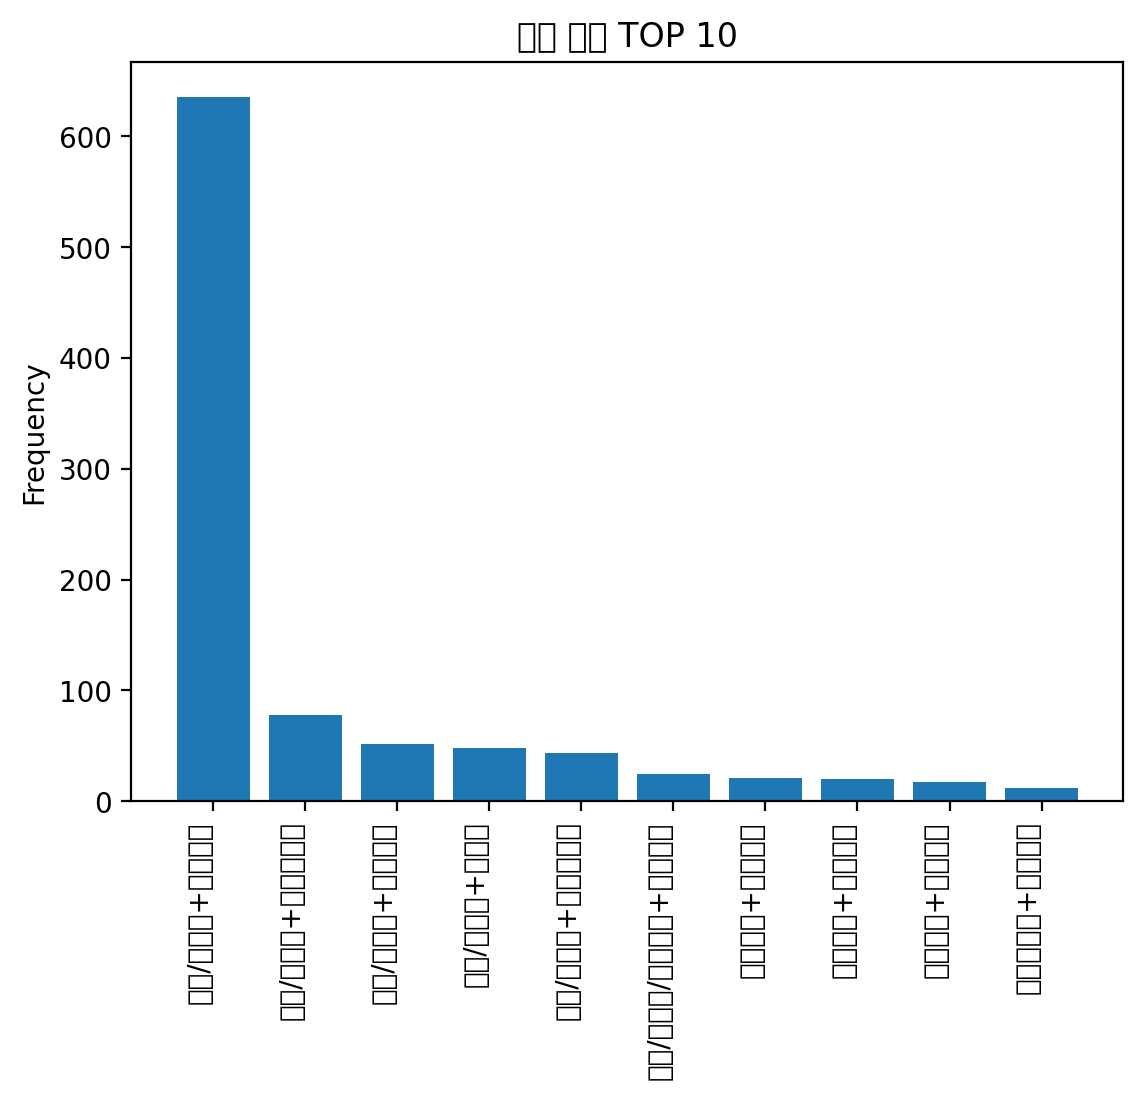

In [230]:
# 빈도수가 가장 높은 메뉴 조합 10개의 이름과 빈도수 추출
names = [combo[0] for combo in most_common_combinations]
counts = [combo[1] for combo in most_common_combinations]

# 막대 그래프 그리기
plt.bar(names, counts)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Frequency')
plt.title('메뉴 조합 TOP 10')
plt.show()

In [231]:
train_ln

,일자,요일,본사정원수,본사휴가자수,본사출장자수,야근자수,재택근무자수,중식메뉴,중식계,밥,국,반찬1,반찬2,반찬3,김치,사이드
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,포기김치,요구르트
1,2016-02-02,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,배추겉절이,요구르트
2,2016-02-03,수,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,포기김치,요구르트
3,2016-02-04,목,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,포기김치,요구르트
4,2016-02-05,금,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,포기김치,요구르트
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,1093,쌀밥/흑미밥/찰현미밥,아욱국,수제함박스테이크,견과류마카로니범벅,생깻잎지,단호박물김치,양상추샐러드*오리엔탈D
1201,2021-01-21,목,2983,92,231,462,351.0,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,832,쌀밥/수수밥/찰현미밥,냉이된장국,동파육,봄동전,청경채/버섯숙회*초장,무생채,양상추샐러드*파인D
1202,2021-01-22,금,2983,255,248,1,303.0,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,579,전주비빔밥*약고추장,계란파국,요거닭,올방개묵무침,파프리카해초무침,포기김치,양상추샐러드*자몽D
1203,2021-01-25,월,2983,107,153,616,327.0,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,1145,쌀밥/흑미밥/찰현미밥,전주식콩나물해장국,돈육간장불고기,깐풍연근,연두부*달래양념장,봄동겉절이/양념김,양상추샐러드*오렌지D


In [232]:
train_ln['총반찬'] = train_ln['반찬1'] + ' ' + train_ln['반찬2'] + ' ' + train_ln['반찬3']

In [233]:
# 카테고리별 키워드 설정
pork_keywords = ['돈', '돼지', '등심', '햄버거', '갈비탕', '갈비찜', '곱창', '불고기']
beef_keywords = ['소', '쇠', '스테이크', '햄버거']
chicken_keywords = ['양념치킨', '치킨', '통닭', '닭', '찜닭', '후라이드', '닭갈비']
seafood_keywords = ['갈치', '광어', '꽁치', '고등어', '멸치', '물회', '새우', '오징어', '조기', '조개', '참치', '해물', '고사리', '미역', '다시마']
vegetable_keywords = ['나물', '무', '배추', '부추', '쌈', '시금치', '쌈채소', '아삭이', '양념채소', '오이', '콩나물', '파', '피클', '고구마', '감자', '채소']
etc_keywords = ['튀김', '파스타', '쌀국수', '볶음밥', '커리', '피자', '만두', '보쌈', '김밥', '우동', '짜장면', '라멘', '김치찌개', '순대', '떡볶이', '콩나물국', '만두국']

In [234]:
# 카테고리화 함수 정의
def categorize_menu(menu):
    menu = str(menu)
    menu = menu.lower()
    if any(keyword in menu for keyword in beef_keywords):
        return '소'
    elif any(keyword in menu for keyword in chicken_keywords):
        return '닭오리'
    elif any(keyword in menu for keyword in pork_keywords):
        return '돼지'
    elif any(keyword in menu for keyword in seafood_keywords):
        return '해물'
    elif any(keyword in menu for keyword in vegetable_keywords):
        return '채소'
    elif any(keyword in menu for keyword in etc_keywords):
        return '기타'
    else:
        return 'unknown'

In [239]:
total_dish = pd.concat([train_ln['반찬1'], train_ln['반찬2'], train_ln['반찬3']])
total_dish_encoded = pd.get_dummies(total_dish.apply(categorize_menu), prefix='총반찬')

total_dish1_encoded = total_dish_encoded[:len(train_ln)]
total_dish2_encoded = total_dish_encoded[len(train_ln):2*len(train_ln)]
total_dish3_encoded = total_dish_encoded[2*len(train_ln):]

train_ln_encoded = pd.concat([train_ln, total_dish1_encoded, total_dish2_encoded, total_dish3_encoded], axis=1)

In [240]:
train_ln_encoded.iloc[1066:1070, 16:]

,총반찬,총반찬_unknown,총반찬_기타,총반찬_닭오리,총반찬_돼지,총반찬_소,총반찬_채소,총반찬_해물,총반찬_unknown,총반찬_기타,...,총반찬_소,총반찬_채소,총반찬_해물,총반찬_unknown,총반찬_기타,총반찬_닭오리,총반찬_돼지,총반찬_소,총반찬_채소,총반찬_해물
1066,양파링카레튀김 모듬어묵볶음 참나물생채,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1067,매운돈갈비찜 메밀전병*간장 고구마순볶음,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1068,홍어미나리초무침 어묵잡채 콩자반,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1069,부추고추전*간장 쫄면야채무침 과일요거트샐러드,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [241]:
train_ln_encoded.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '야근자수', '재택근무자수', '중식메뉴',
       '중식계', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '총반찬', '총반찬_unknown',
       '총반찬_기타', '총반찬_닭오리', '총반찬_돼지', '총반찬_소', '총반찬_채소', '총반찬_해물',
       '총반찬_unknown', '총반찬_기타', '총반찬_닭오리', '총반찬_돼지', '총반찬_소', '총반찬_채소',
       '총반찬_해물', '총반찬_unknown', '총반찬_기타', '총반찬_닭오리', '총반찬_돼지', '총반찬_소',
       '총반찬_채소', '총반찬_해물'],
      dtype='object')